
Может быть можно в большой картинке отключать градиенты у части картинки и фокусироваться лишь на части, может быть это освободить скольок-то оперативки?


negative generating - тема для статьи?

сначала генерирование с держанием подальше от конкретных семантических оборотом

потом просто бец цели, лишь указывая что нельзя рисовать. Не цель, но ограничения

1. [ ] Надо нормализовать функцию потерь в зависимости от количества запросов

In [1]:
#ideas

1. noise to some parts of image
2. helper texts with pattern: this is {}, a picture of  {}
3. high quality, image

SyntaxError: invalid syntax (261694274.py, line 3)

In [ ]:
#%git clone https://github.com/CompVis/taming-transformers.git
%pip install git+https://github.com/illeatmyhat/taming-transformers #a taming transformers version for pip install
#pip install taming-transformers


In [ ]:
%pip install ruclip, cython

%pip install omegaconf
%pip install pytorch_lightning
%pip install einops
%pip install gdown
%pip install matplotlib

In [2]:


import ipywidgets as widgets
from IPython.display import display

layout = widgets.Layout(display='flex',
         flex_flow='row',
         #border='solid',
         width='50%')

box_img=widgets.Box(layout=layout)

target_text_label=widgets.Label('---')
score_loss_label=widgets.Label('---')
score_label=widgets.Label('---')
quantize_label=widgets.Label('---')
iter_label=widgets.Label('---')

onflight_image=widgets.Image()

box_scores=widgets.VBox([iter_label,target_text_label, score_label,score_loss_label,quantize_label])
box=widgets.Box([onflight_image,box_scores,box_img])
display(box)

Box(children=(Image(value=b''), VBox(children=(Label(value='---'), Label(value='---'), Label(value='---'), Lab…

In [3]:
from gantenna.style_settings import StyleSettings
#style settings 
style=StyleSettings()
style.like('панельки ночью')
style.far_from('небо')

learning_rate=0.01
img_size=224
noise_add_percent=0 # %
verbose=False
iterations=5000
add_noise_every_iterations=1000

score_threshold_to_reduce_lr=1.

score_loss_weight=0.
dist_loss_weight=1.

ModuleNotFoundError: No module named 'gantenna'

In [ ]:
#vqgan loading
import sys
#sys.path.append("./taming-transformers") #workaround for bitch taming tranformers

from pathlib import Path
import gdown
import os
from omegaconf import OmegaConf
import yaml
from taming.models.vqgan import GumbelVQ
import torch

def download_vqgan(models_dir='models'):
    models_folder= Path(models_dir)
    model_path= models_folder / 'sber.gumbelf8.ckpt'
    config_path= models_folder / 'vqgan.gumbelf8.config.yml'
    if (model_path.exists() 
        and model_path.is_file()
        and config_path.exists()
        and config_path.is_file()):
        #already downloaded
        return model_path, config_path

    url_template = 'https://drive.google.com/uc?id={}'
   

    os.makedirs(models_folder,exist_ok=True)

    downloads=[
        {
        'id': '1M7RvSoiuKBwpF-98sScKng0lsZnwFebR',
        'name': 'vqgan.gumbelf8.config.yml',
        },
        {
        'id': '1WP6Li2Po8xYcQPGMpmaxIlI1yPB5lF5m',
        'name': 'sber.gumbelf8.ckpt',
        },
    ]

    for item in downloads:
        out_name = os.path.join(models_folder, item['name'])
        url = url_template.format(item['id'])
        gdown.download(url, out_name)


    return model_path, config_path

def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def load_vqgan(models_dir='models') -> GumbelVQ:

    model_path, config_path=download_vqgan(models_dir=models_dir)
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    config=load_config(config_path=config_path)
    model = GumbelVQ(**config.model.params)
    if model_path is not None:
        sd = torch.load(model_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval().to(DEVICE)

In [ ]:
import ruclip

device = 'cuda'
def load_ruclip(name='ruclip-vit-base-patch32-224',models_dir='models'):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    clip, processor = ruclip.load(name, device=DEVICE,cache_dir=models_dir)
    return clip, processor

In [ ]:
vq=load_vqgan()
clip,processor=load_ruclip()

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


In [ ]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import PIL
from PIL import Image

import numpy as np



def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def crop(img, target_image_size=256):
    s = min(img.size)
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    return img

def preprocess(img, target_image_size=256):
    img=crop(img,target_image_size=target_image_size)
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    img=preprocess_vqgan(img)
    return img
    
def vqgan_postprocess(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def vqgan_postprocess_with_grad(x):
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0)
    image=x.detach().cpu().numpy()
    image=(255*image).astype(np.uint8)
    x = (255*x)
    image = Image.fromarray(image)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    return x, image

def reconstruct_with_vqgan(x, model):
    with torch.no_grad():
        z, _, [_, _, indices] = model.encode(x)
        xrec = model.decode(z)
    return xrec

In [ ]:
#clamper
import math

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

In [ ]:
#check it works



import requests
import io

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

# img=download_image(img_url)
# display(crop(img,target_image_size=256))

# x=preprocess(img,target_image_size=256).to(DEVICE)
# #x=map_pixels(x)
# out1=reconstruct_with_vqgan(x,vq)[0] # returns array
# #x=unmap_pixels(x)
# out1=vqgan_postprocess(out1)


# display(out1)

In [ ]:


def add_noise(tensor, percent=1):
        noise=torch.rand_like(tensor)
        return tensor+percent*0.01*noise

def add_white(tensor, percent=1):
        white=torch.ones_like(tensor)
        return tensor+percent*0.01*white

def vector_quantize(h, vq:GumbelVQ):
        #not works
        h_c = vq.quant_conv(h)
        quant, emb_loss, info = vq.quantize(h_c)
        #quant.names=('Quant','a','b','c')
        return quant #replace_grad(quant, h_c)

codebook=vq.quantize.embed.weight
def vector_quantize_kate(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


#img_url='https://img.gazeta.ru/files3/291/12697291/upload-RTX75B8J-pic905-895x505-4746.jpg'
#img_url='https://7minutes.ru/wp-content/uploads/2017/06/Розовый-шум.jpg'
#img=download_image(img_url)
#img=crop(img,target_image_size=img_size)

#take my z
import torchvision

normalize=torchvision.transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                    std=[0.26862954, 0.26130258, 0.27577711])

z_min = vq.quantize.embed.weight.min(dim=0).values[None, :, None, None]
z_max = vq.quantize.embed.weight.max(dim=0).values[None, :, None, None]

with torch.no_grad():
        #x=preprocess(img,target_image_size=img_size).to(DEVICE)
        #print('max x',x.max())
        #print('min x',x.min())
        #x=x*0.0 - 1.
        x=torch.zeros(size=(1,3,img_size,img_size)).to(DEVICE)
        x=add_noise(x,50)
        #x=add_white(x,100)
        z, *_ = vq.encode(x)
        del vq.encoder # free vram! ✊
        #z=vq.encoder(x)
z.requires_grad_(True)

optimizer=torch.optim.Adam([z], lr=learning_rate)

#xrec = vq.decode(z)
#print('max xrec init',xrec.max())
#print('min xrec init',xrec.min())

#xrec=normalize(xrec)
#img=vqgan_postprocess(xrec[0])
#display(img)
#get my text



#make image



# #print('clip image_size',clip.visual.input_resolution)
# classes = ['дом в стиле брутализм', 'толпа', 'чет так', 'люди']
# tolpa_logit=0
# with torch.no_grad():
#         text_tokens= processor(classes)
#         text_features=clip.encode_text(text_tokens['input_ids'].to(DEVICE)).to(DEVICE)
#         text_latents = text_features / text_features.norm(dim=-1, keepdim=True) # runs backward pass
#torch.autograd.set_detect_anomaly(True)
learning_rate_changed=False

c:\Users\cuda\my_vq\_local_env\lib\site-packages\torch\nn\functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


noise added
noise added
noise added
noise added


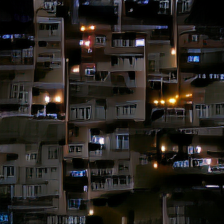

In [ ]:

rotate=T.RandomRotation(30)

positive_prompts, negative_prompts = style.make_embeds(clip=clip, clip_processor=processor)

dists_pos_plot=[]

def encode_bs(clip, images:torch.Tensor, bs=1):
        batches=images.split(1)
        results=[clip.encode_image(batch) for batch in batches]
        return torch.cat(results)

# predict
for i in range(1,iterations):
        z_q=vector_quantize_kate(z.movedim(1,3),codebook=codebook).movedim(3,1)
        xrec = vq.decode(z_q)

        x_aug=(torch.cat(
                T.FiveCrop(150)(xrec)#+ T.FiveCrop(100)(xrec)# packing list of five tensors
                ))
        x_aug=F.upsample(x_aug,(224,224))
        x_aug=(torch.cat(
                [xrec,x_aug]#+ T.FiveCrop(50)(xrec)# packing list of five tensors
                ))     

        x_aug=rotate(x_aug)

        xrec_q=(x_aug+1.0)/2.
        xrec_q=add_noise(xrec_q,percent=noise_add_percent)
        xrec_q=clamp_with_grad(xrec_q,0,1)
        xrec_q=normalize(xrec_q) #arter clamping!
        #image_features=clip.encode_image(xrec_q).to(DEVICE)
        image_features=encode_bs(clip, xrec_q)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True) # runs backward pass
        image_latents=image_features

        logit_scale=clip.logit_scale.exp()
        logits_per_text = torch.matmul(positive_prompts.to(DEVICE), image_latents.t()) #* logit_scale

        dist = image_features.sub(positive_prompts[0]).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

        #dists_positive =torch.cat([image_features.sub(prompt).norm(dim=-1).div(2).arcsin().pow(2).mul(2) for prompt in positive_prompts])        
        #dists_negative =torch.cat([image_features.sub(prompt).norm(dim=-1).div(2).arcsin().pow(2).mul(2) for prompt in negative_prompts])

        dists_positive =[image_features.sub(prompt).norm(dim=-1).div(2).arcsin().pow(2).mul(2) for prompt in positive_prompts]        
        dists_negative =[image_features.sub(prompt).norm(dim=-1).div(2).arcsin().pow(2).mul(2) for prompt in negative_prompts]

        #print('dists',dists)
        #print('logits',logits_per_text)
        tolpa_logit=logits_per_text[0]
        #print(logits_per_text.grad_fn)
        #print(tolpa_logit)
        loss_clip=F.mse_loss(tolpa_logit,(torch.ones_like(tolpa_logit)*2.0).to(DEVICE)) # NOT 1.0 the values are like 15.0 -20.0 for good match
        loss_dist=(
                sum([F.mse_loss(dist, torch.zeros_like(dist).to(DEVICE)) for dist in dists_positive])
                + sum([F.mse_loss(dist, (1*torch.ones_like(dist)).to(DEVICE)) for dist in dists_negative])
                )
        

        # we need to get xrec less then 2 more close to 1,5
        dark_pic= torch.zeros(size=xrec.shape).to(DEVICE)
        #darkness_weight=0
        #loss_bright=darkness_weight*F.mse_loss(xrec,dark_pic)

        #full loss
        loss=score_loss_weight*loss_clip + dist_loss_weight*loss_dist #+loss_bright
        loss.backward(retain_graph=True)
        #z_orig=z
        optimizer.step()

        with torch.no_grad():
            z.copy_(z.maximum(z_min).minimum(z_max)) # took from kate crow
                                                # starts faster
                                                # more blurry
                                                # more consistent?
        #delta_z:torch.Tensor=z-z_orig
        #print(delta_z.max())
        #xrec = vq.decode(z)
        

        img=vqgan_postprocess(xrec[0])

        del xrec  # free ram
        import gc
        gc.collect()
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        
        if i%10==0:  
                new_widget=widgets.Image(value=img_byte_arr)
                box_img.children=tuple([new_widget]+list(box_img.children[:5]) )
                #display(img)
        onflight_image.value=img_byte_arr
        target_text_label.value=f'+ {style.positive_prompts} \n\n - {style.negative_prompts}'
        iter_label.value=f'iter #{i}'
        score_label.value=f'score: {[logit.item() for logit in tolpa_logit]}'
        score_loss_label.value=f'score loss: {loss_clip.item()}'
        quantize_label.value=f'Learning rate {"not" if not learning_rate_changed else ""} changed'
        
        #somehow a lot of noise wors sooo goood!!!
        if i%add_noise_every_iterations==0:
                with torch.no_grad():
                        #z_new:torch.Tensor=z+torch.randn_like(z)*1
                        z.add_(torch.randn_like(z)*2)
                        print('noise added')
                        #add noise to z_q? every step
                
        

        # with torch.no_grad():
        #     z.copy_(z.maximum(z_min).minimum(z_max))
        #xrec=normalize(xrec)
        optimizer.zero_grad() # xrec wont grow that fast
        

#USE THIS
# def forward(self, input):
#         input_normed = F.normalize(input.unsqueeze(1), dim=2)
#         embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
#         dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
#         dists = dists * self.weight.sign()
#         return self.weight.abs() * replace_grad(dists, torch.msaximum(dist, self.stop)).mean()


xrec = vq.decode(z_q)
img=vqgan_postprocess(xrec[0])
display(img)

del xrec # 2gb of vram lol

In [ ]:
image_features.shape

torch.Size([6, 512])

In [ ]:
negative_prompts.shape

torch.Size([1, 512])

In [ ]:
dists = torch.cat([image_features.sub(prompt).norm(dim=-1).div(2).arcsin().pow(2).mul(2) for prompt in negative_prompts])

In [ ]:
dists.shape

torch.Size([6])

In [ ]:
loss=F.mse_loss(dists, torch.tensor(torch.zeros_like(dists)).to(DEVICE))

C:\Users\cuda\AppData\Local\Temp\ipykernel_29224\1775915048.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss=F.mse_loss(dists, torch.tensor(torch.zeros_like(dists)).to(DEVICE))


In [ ]:
loss.backward()